In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import time

from libworm.model.beta_neuron import NeuronNetwork, from_connectome
from libworm.data import connectomes, traces
from libworm import preprocess
from libworm.functions import set_neurons, tcalc_s_inf, set_trace
from libworm.data.neuron import full_sensory_list

from math import tau

In [2]:
def setup(G_syn_value = 100.0, 
            G_gap_value = 100.0,
            G_leak_value = 10.0):
    _, trace, trace_labels, label2index, timestamps = traces.load_trace()
    timestamps = timestamps - timestamps[0]
    
    chemical, gapjn = connectomes.load_cook_connectome()
    neurons = connectomes.get_main_neurons(chemical, gapjn)
    neurons.sort(key=lambda item: f"AAA{label2index[item]:04d}{item}" if item in label2index else item)
    model = from_connectome(chemical,
                            gapjn,
                            neurons,
                            V_value=0.0,
                            G_gap_value=G_gap_value,
                            G_syn_value=G_syn_value,
                            G_leak_value=G_leak_value)
    
    cell = "SMBVR"
    
    not_in_main_section = [label2index[key] for key in label2index if key not in neurons]
    not_labelled = [i for i, _ in enumerate(trace[:, 0]) if i not in label2index.values()]
    
    removal = list(set(not_in_main_section).union(not_labelled))
    
    trace = np.delete(trace, removal, axis=0)
    
    trace_pairs = [(time, trace[:, i]) for i, time in enumerate(timestamps)]

    return model, trace_pairs, neurons

In [3]:
def eval(model, start_index, data, dt=0.01, limiter=True):

    for i in range(15):
        runtime =  data[start_index + i + 1][0] - data[start_index + i][0]
        points = data[start_index + i][1]
        model.big_V[:len(points)] = points
        model.simple_run(dt, runtime, show_progress=False, limiter=limiter)

    start_index += 15
    
    for i in range(15):
        runtime =  data[start_index + i + 1][0] - data[start_index + i][0]
        model.simple_run(dt, runtime, show_progress=False, limiter=limiter)

    print("Eval Complete")

    

## Standard From 0

##########

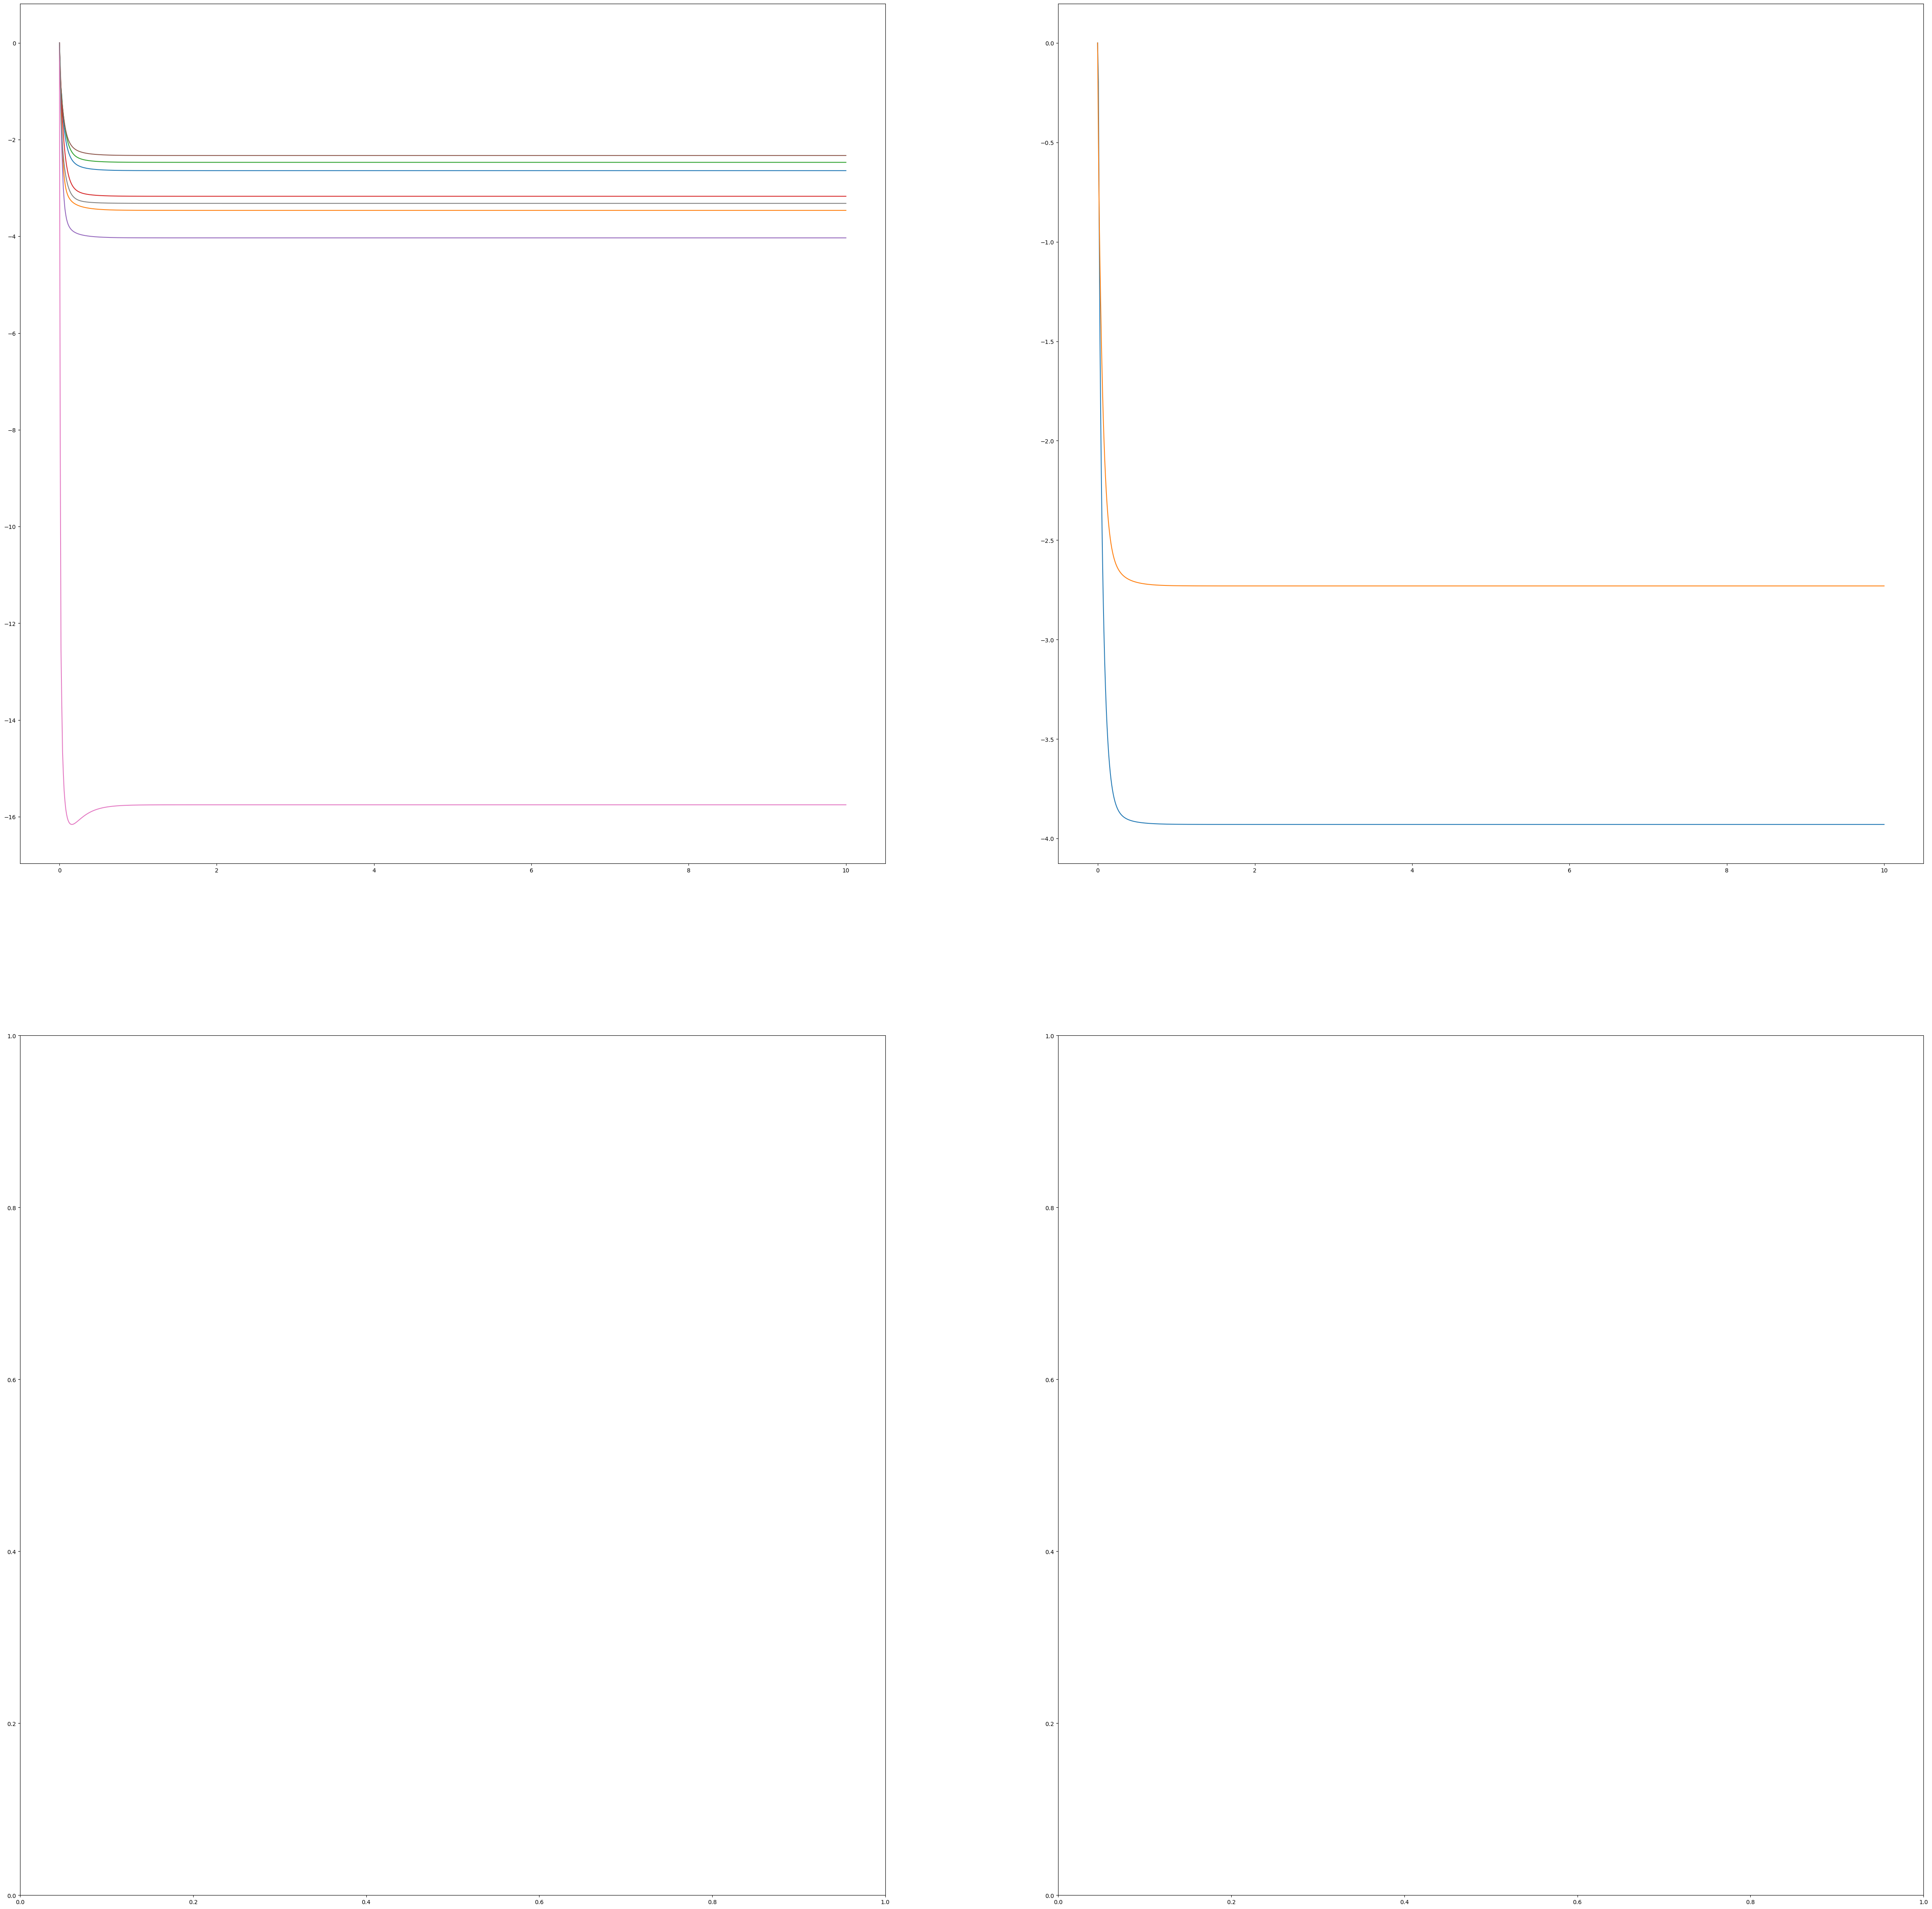

In [6]:
model, data, neurons = setup()
model.simple_run(0.01, 10.0)
model.show_large_voltage_data(count=10)

## Standard Eval Trace Data

Eval Complete


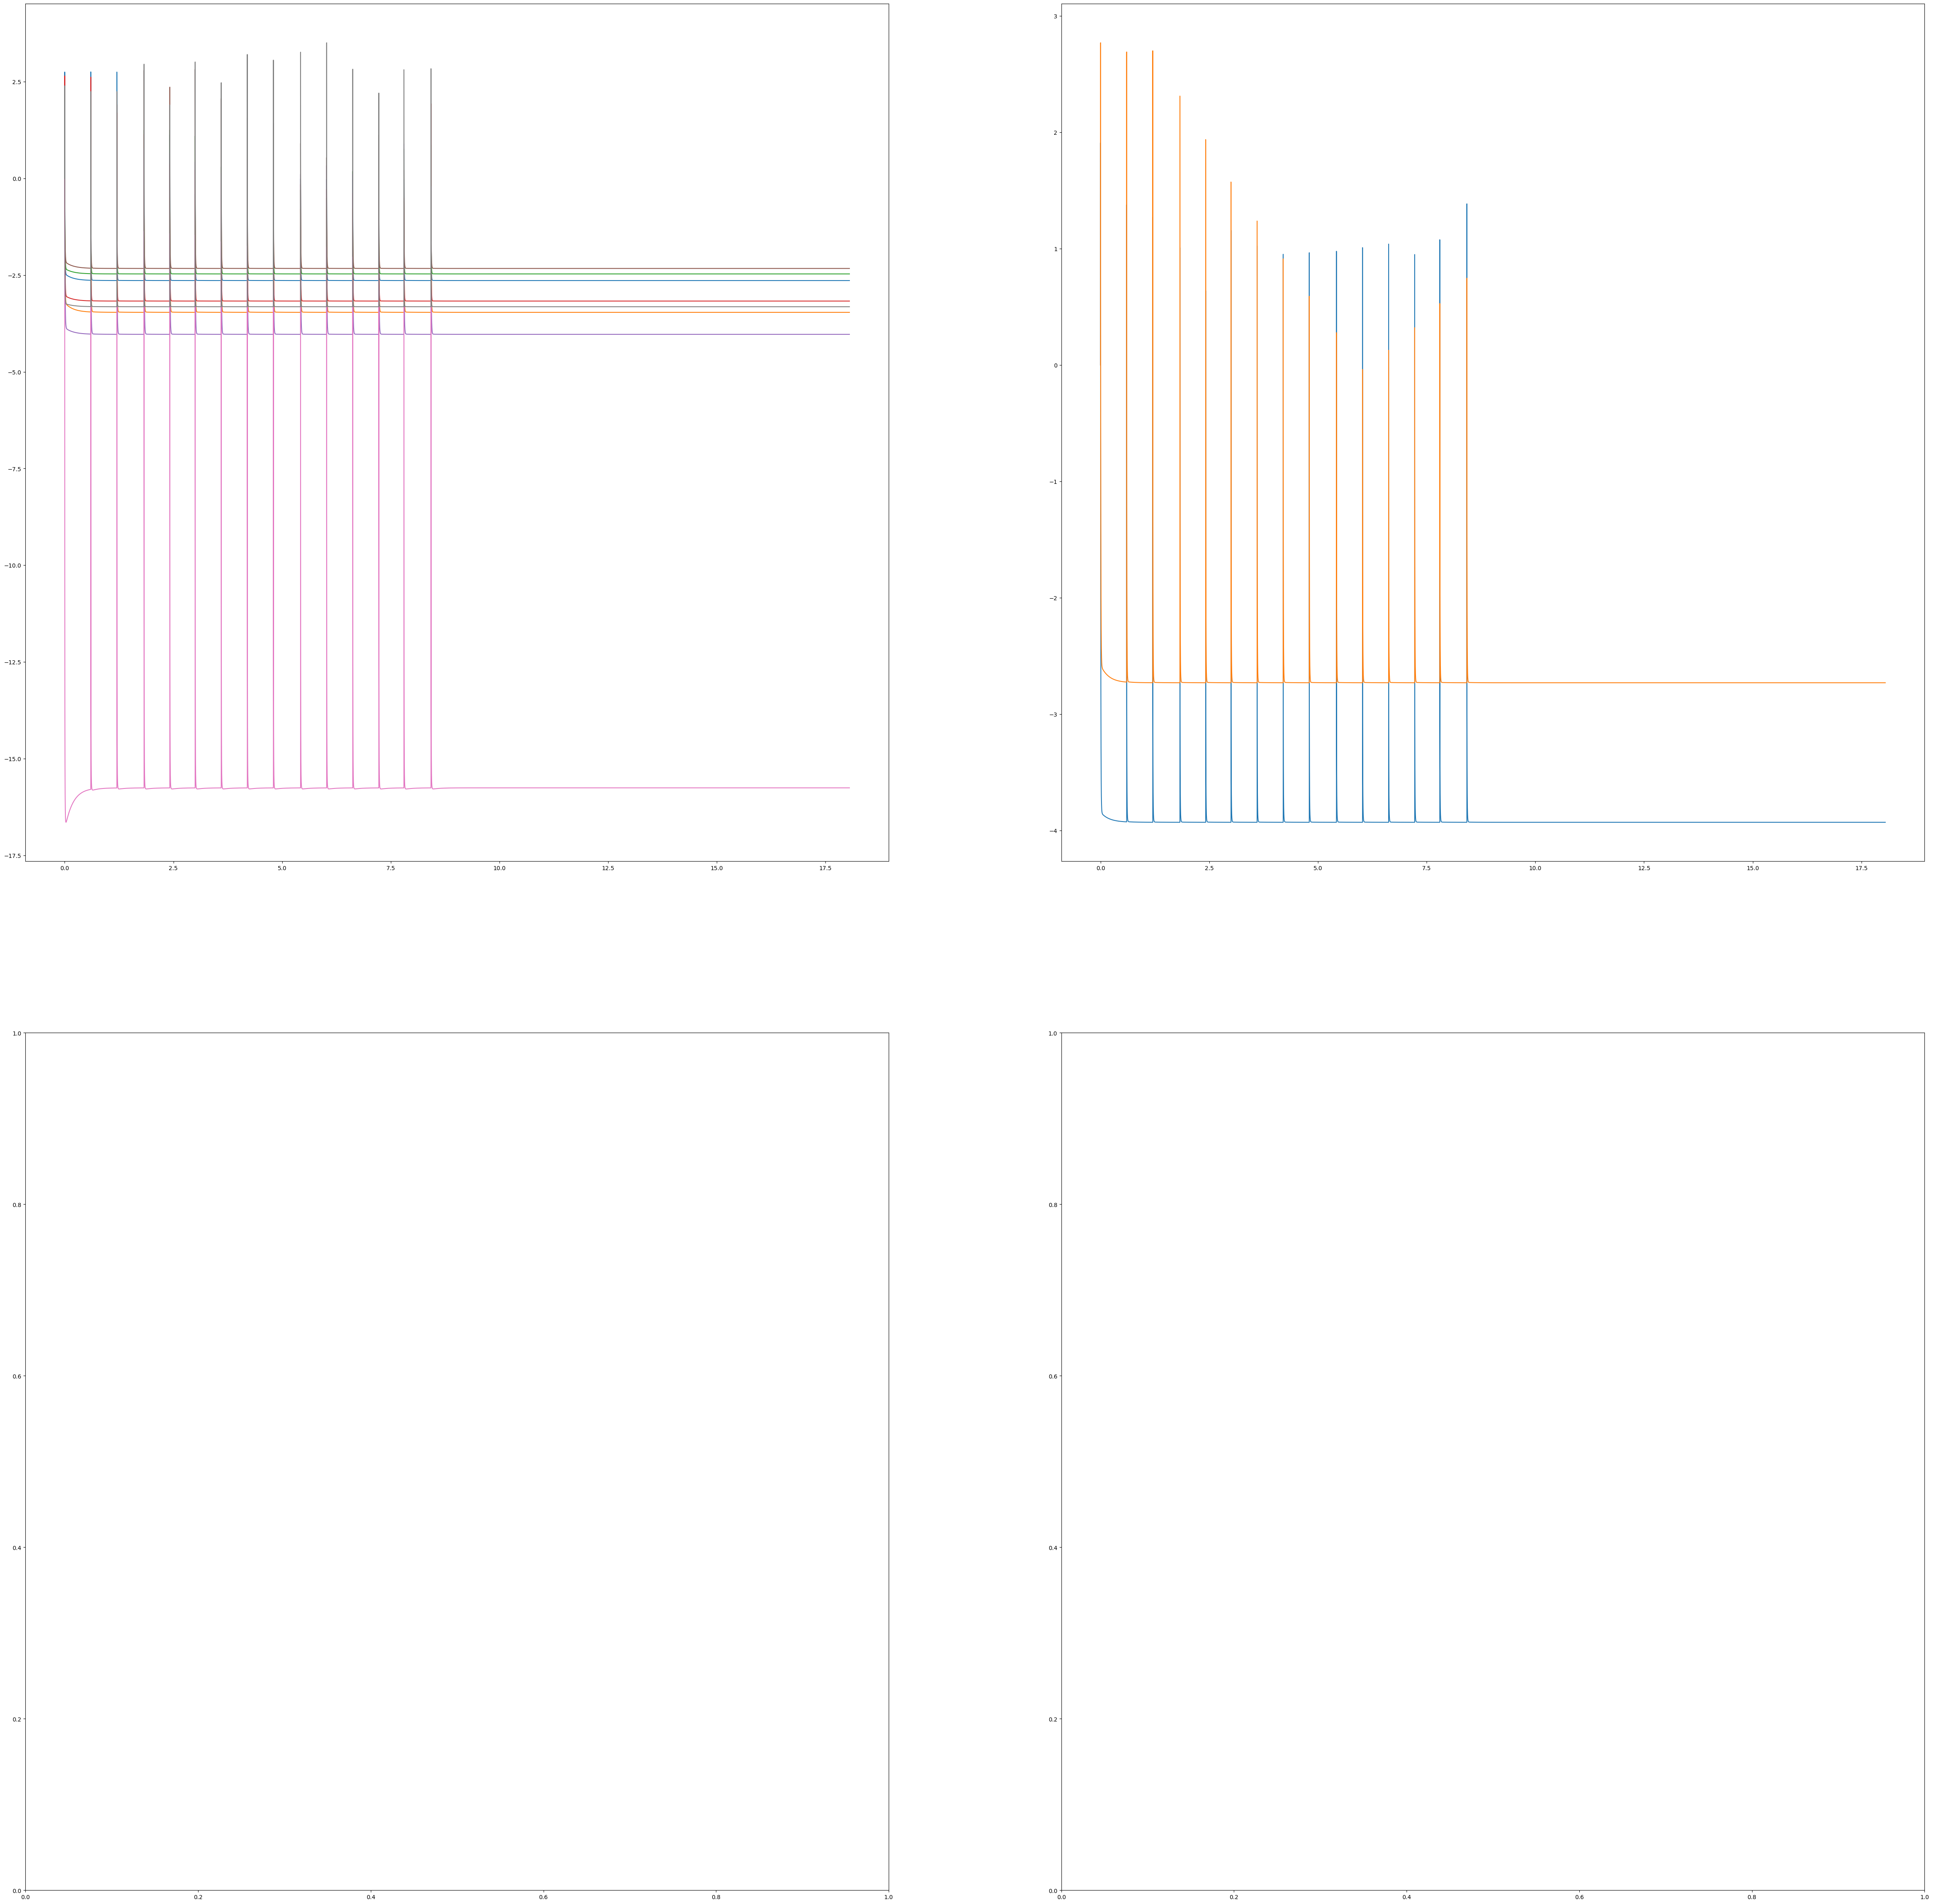

In [7]:
model, data, neurons = setup()
eval(model, 0, data, dt=0.0001, limiter=False)
model.show_large_voltage_data(count=10)

## Reduced Conductance Eval Trace Data

##########

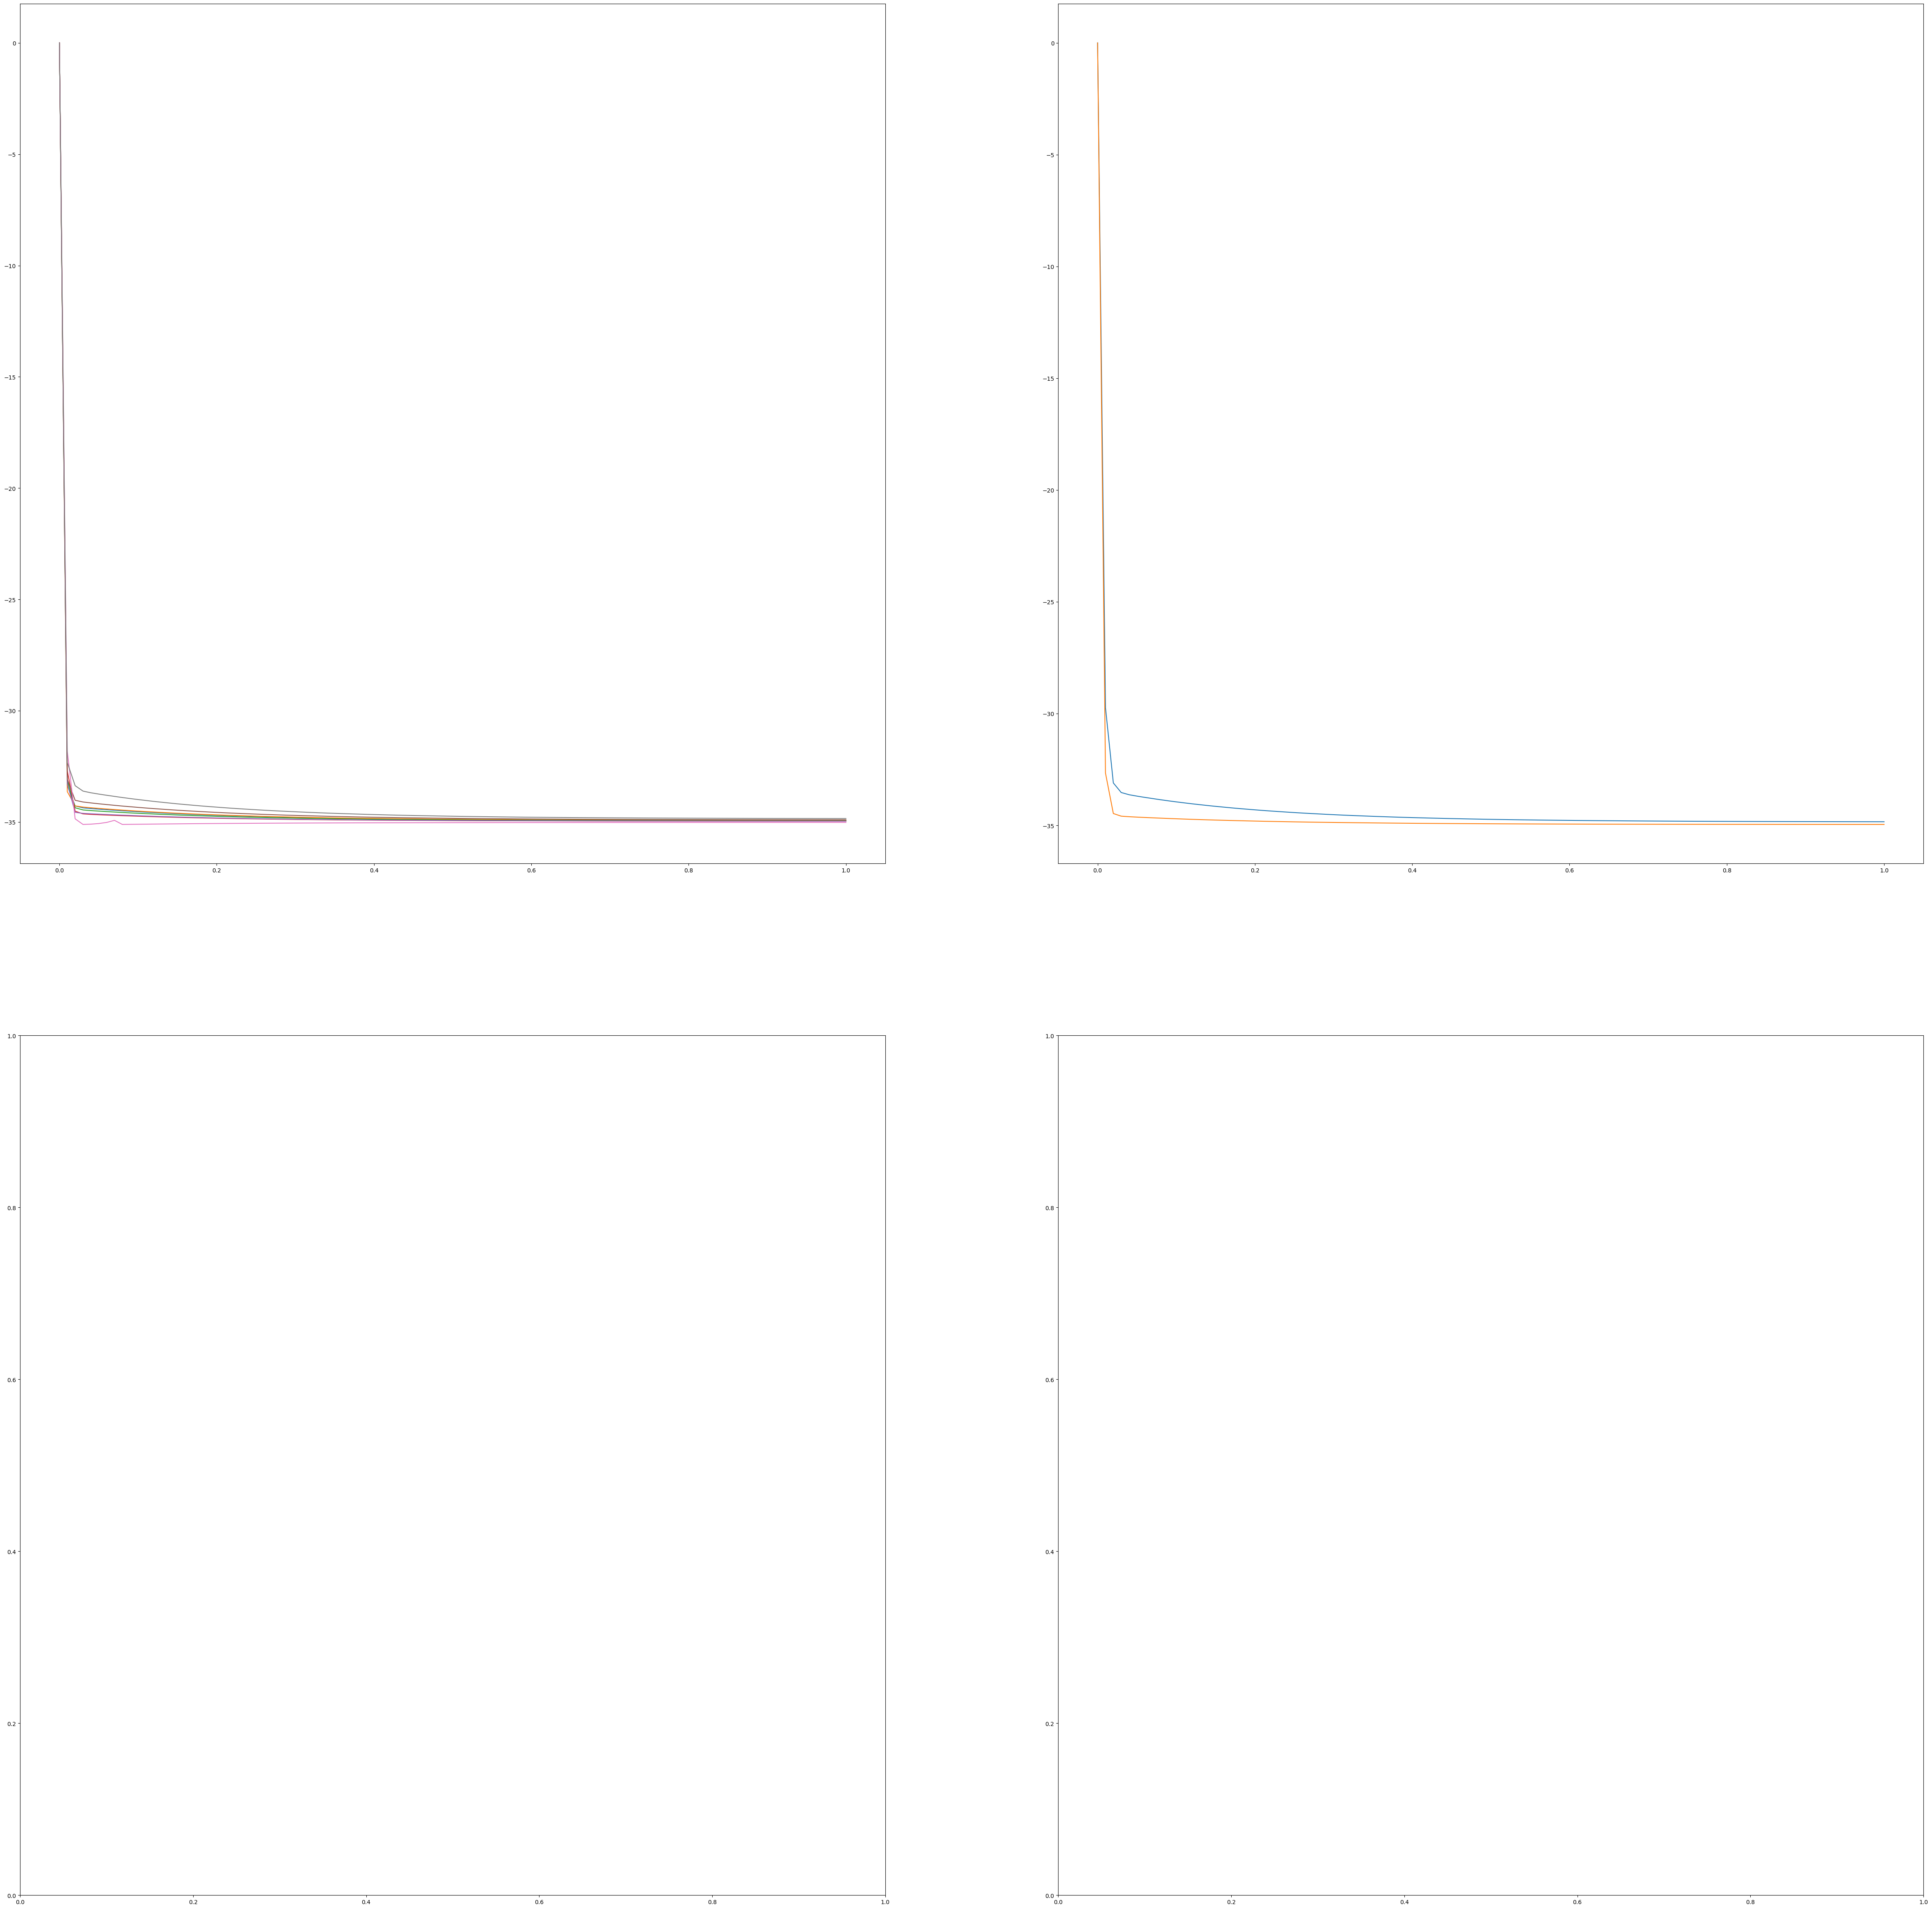

In [6]:
model, data, neurons = setup(0.1, 0.1, 1000)
#eval(model, 0, data, dt=0.01, limiter=True)
model.simple_run(0.01, 1.0)
model.show_large_voltage_data(count=10)

Eval Complete


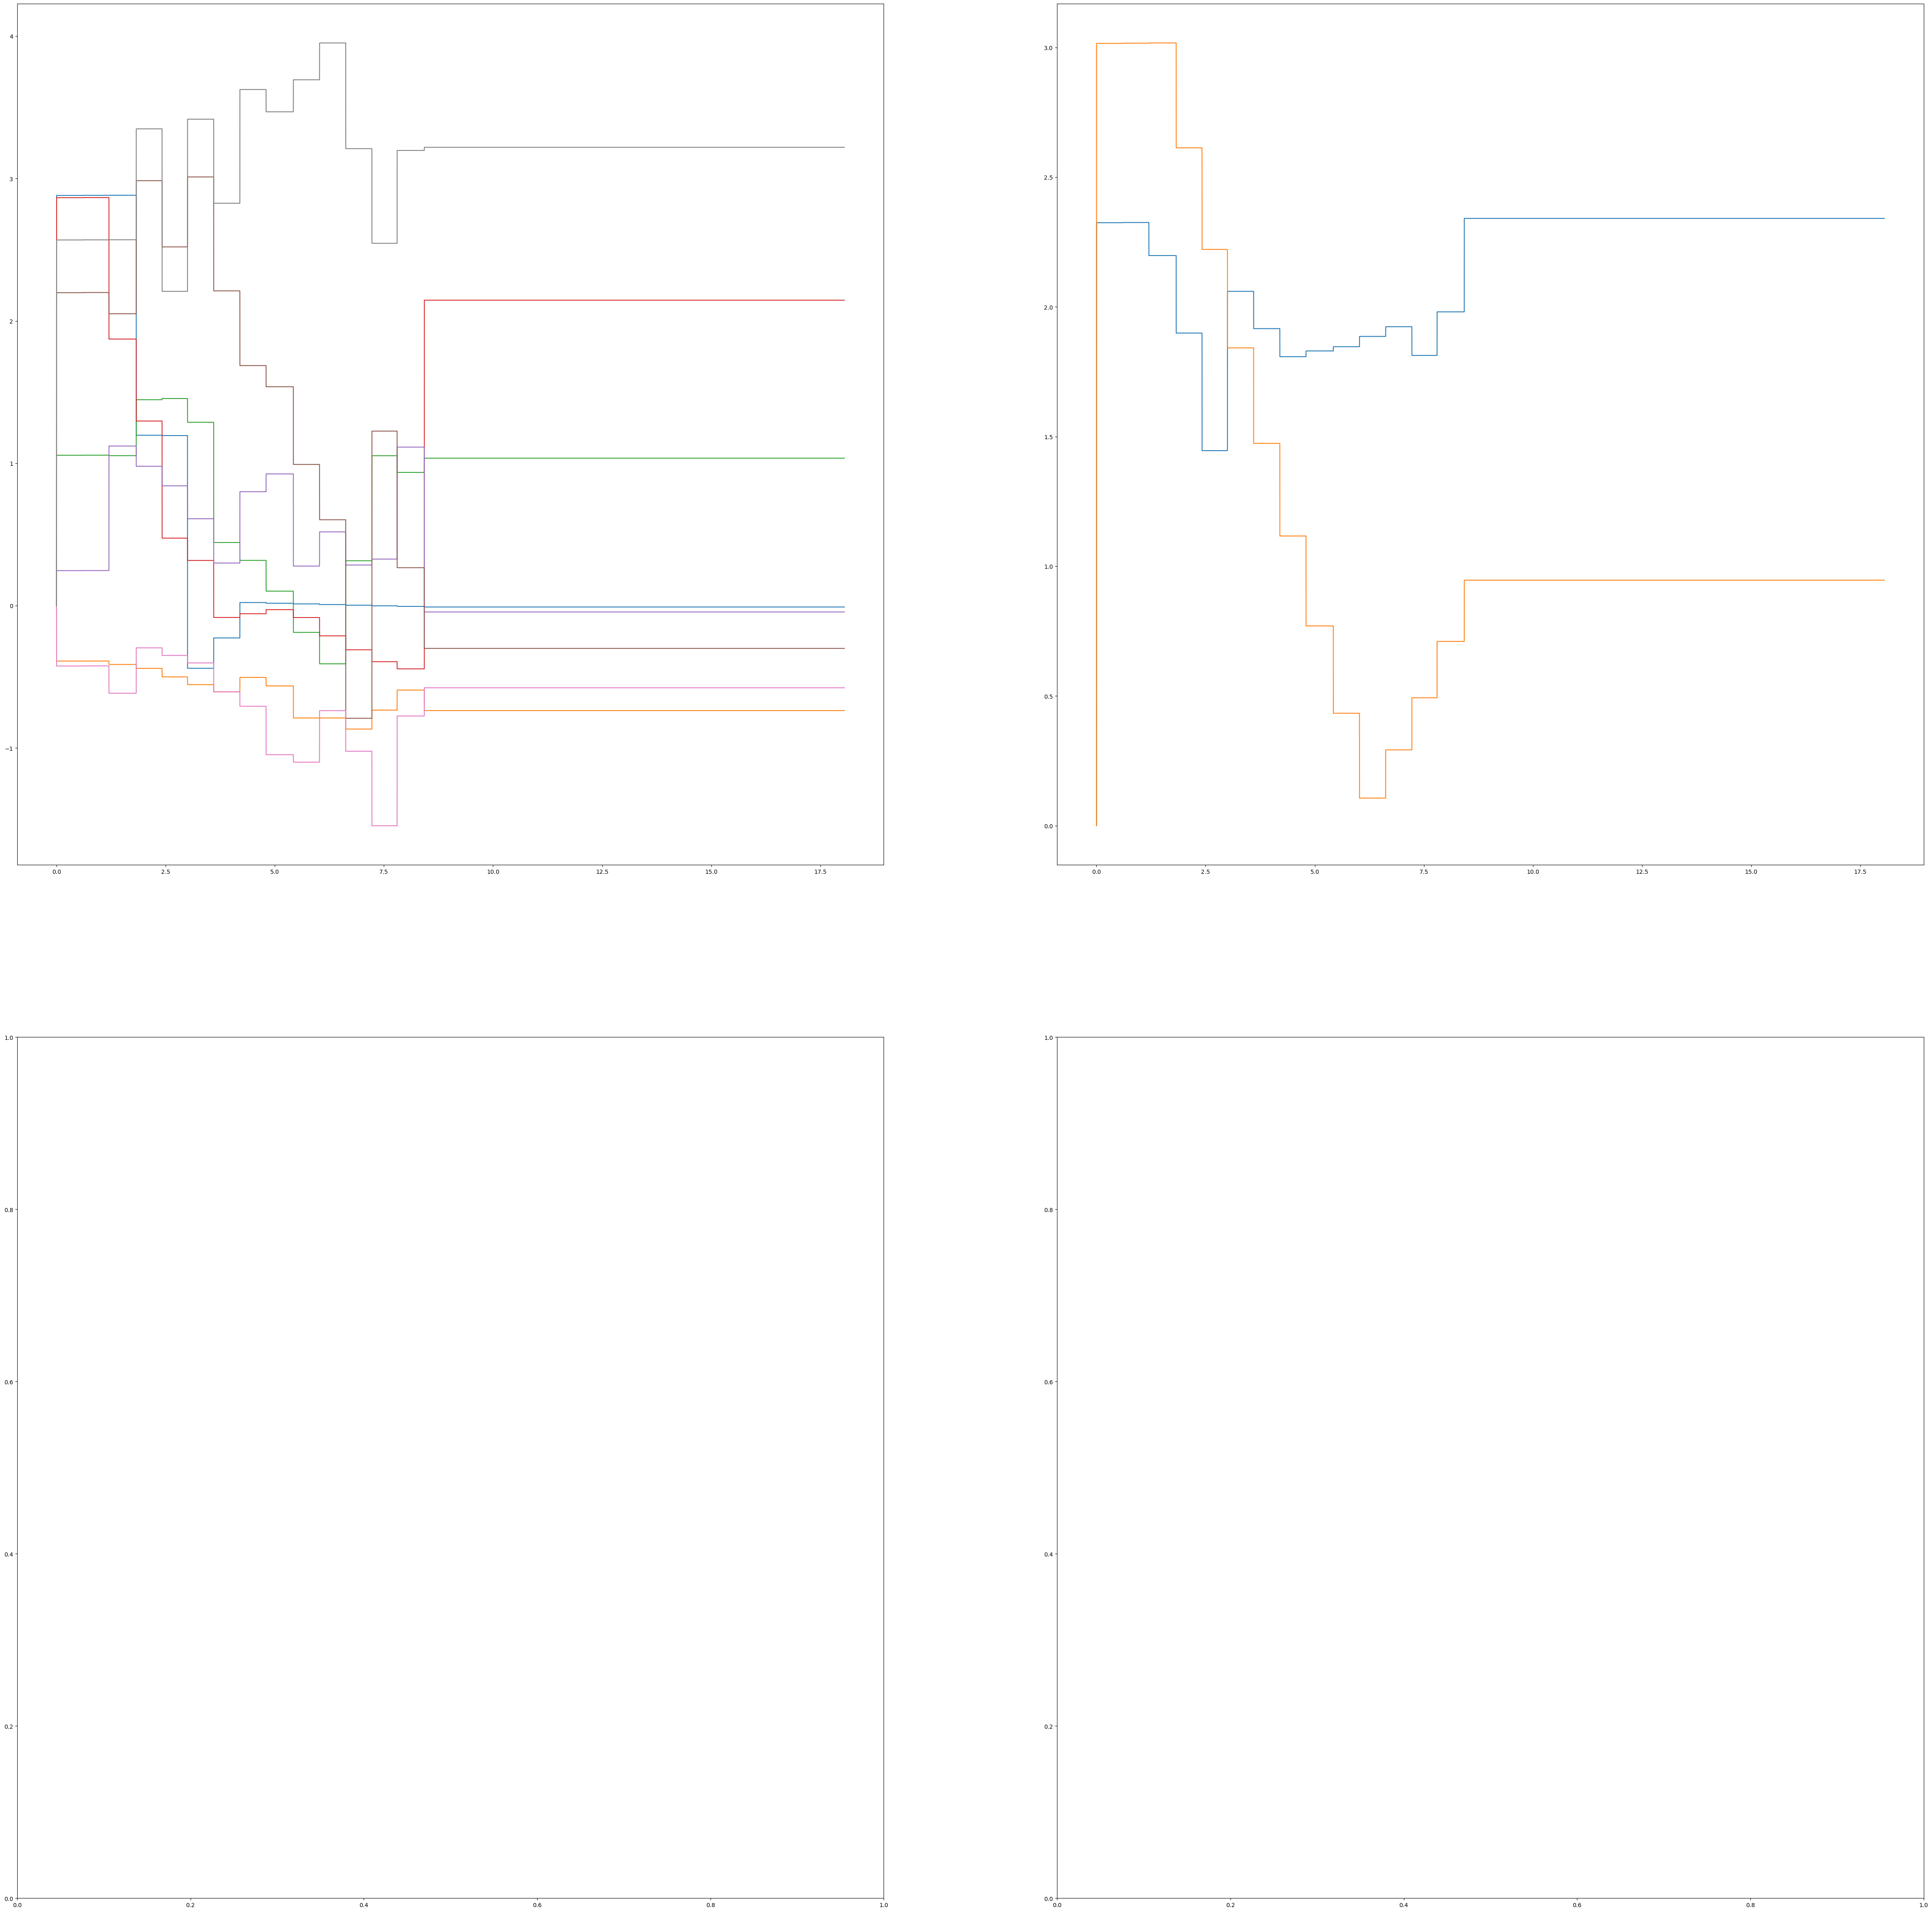

In [5]:
model, data, neurons = setup(0.0, 0.0, 0.0)
eval(model, 0, data, dt=0.0001, limiter=False)
model.show_large_voltage_data(count=10)

In [7]:
model.big_G_syn

array([[  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0., 100.],
       [  0.,   0.,   0., ...,   0.,   0., 100.]])

## Sensory Oscillator

In [7]:
sensory_indices = [neurons.index(cell) for cell in full_sensory_list]

def oscillator(time):
    value = np.clip((np.sin(time * tau) * 1000.0), 0, 1) * 1000.0
    return [0 if i not in sensory_indices else value for i in range(280)]

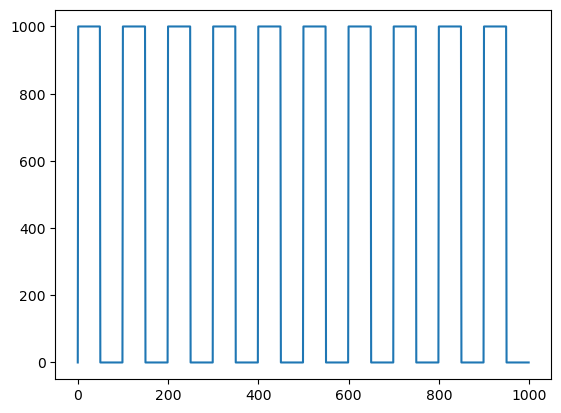

In [7]:
test = np.array([oscillator(t) for t in np.linspace(0, 10, 1000)])
plt.plot(test[:, 1])

In [4]:
model, data, neurons = setup()
model.adv_run(0.01, 10.0, oscillator)
model.show_large_voltage_data()

NameError: name 'oscillator' is not defined

## Sensory Oscillator With Offset

In [7]:
neurons.index('ASHR')

128

In [5]:
sensory_indices = [neurons.index(cell) for cell in full_sensory_list]

def oscillator_with_offset(time):
    value = lambda a: np.clip((np.sin(time * tau + a) * 1000.0), 0, 1) * 1000.0
    return [0 if i not in sensory_indices else value(i) for i in range(280)]

####################

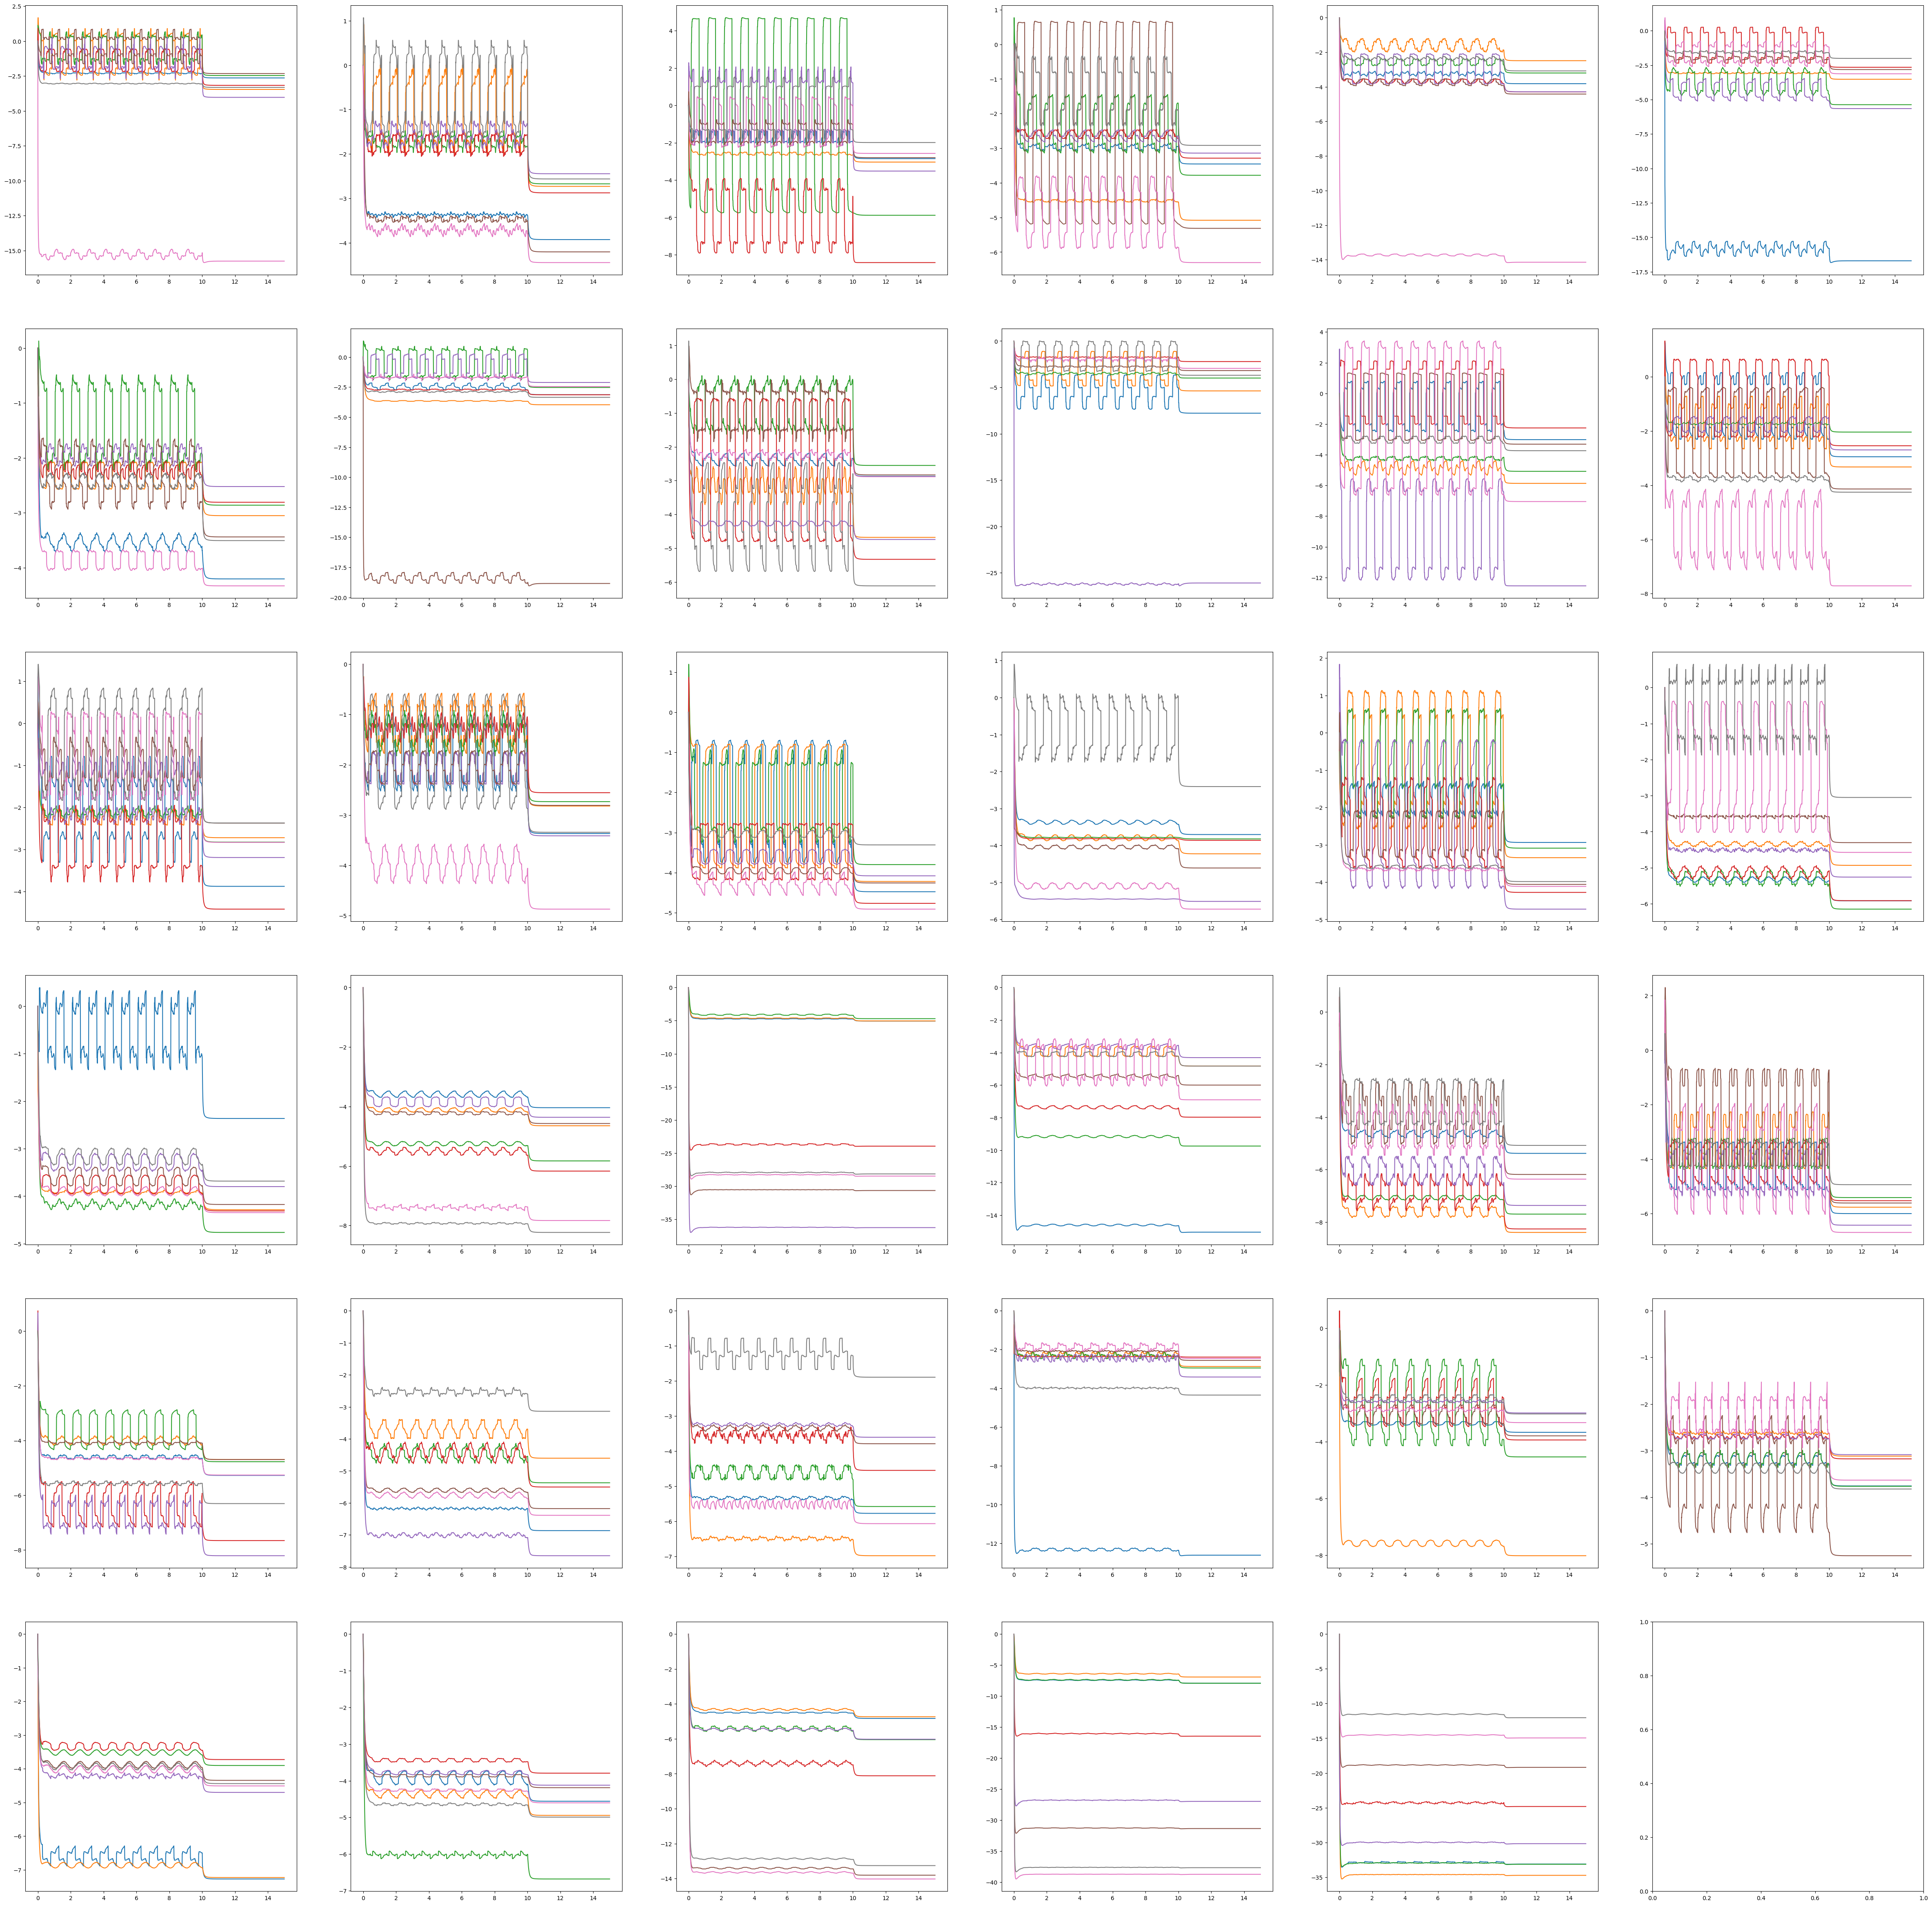

In [6]:
model, data, neurons = setup()
model.adv_run(0.01, 10.0, oscillator_with_offset)
model.simple_run(0.01, 5.0)
model.show_large_voltage_data()

# Constant Input to PLM

In [11]:
model, data, neurons = setup()
plm_index = [neurons.index("PLML"), neurons.index("PLMR")]

def plm_input(time):
    return [0 if i not in plm_index else 1000.0 for i in range(280)]

In [12]:
plm_index

[187, 188]

In [13]:
model.adv_run(0.001, 10.0, plm_input, limiter=True)
model.show_large_voltage_data()

###

KeyboardInterrupt: 

## Sensory Input From Trace w/ Interpolation

In [14]:
model, data, neurons = setup()

sensory_indices = [neurons.index(cell) for cell in full_sensory_list]

def interpolated_input(time):
    
    for i, (frame_time, frame) in enumerate(data):
        if frame_time > time:
            frame_b = frame
            frame_a = data[i-1][1]

            a_time = data[i-1][0]
            diff = frame_time - a_time
            distance = (time - a_time) / diff
            break
    
    return [(frame_a[i] * (1-distance) + frame_b[i] * distance) * 1000.0 if i < len(frame_a) and i in sensory_indices else 0 for i in range(280)]



In [15]:
re_trace = np.array([frame for time, frame in data])

In [16]:
model.adv_run(0.01, 10.0, interpolated_input)

##########

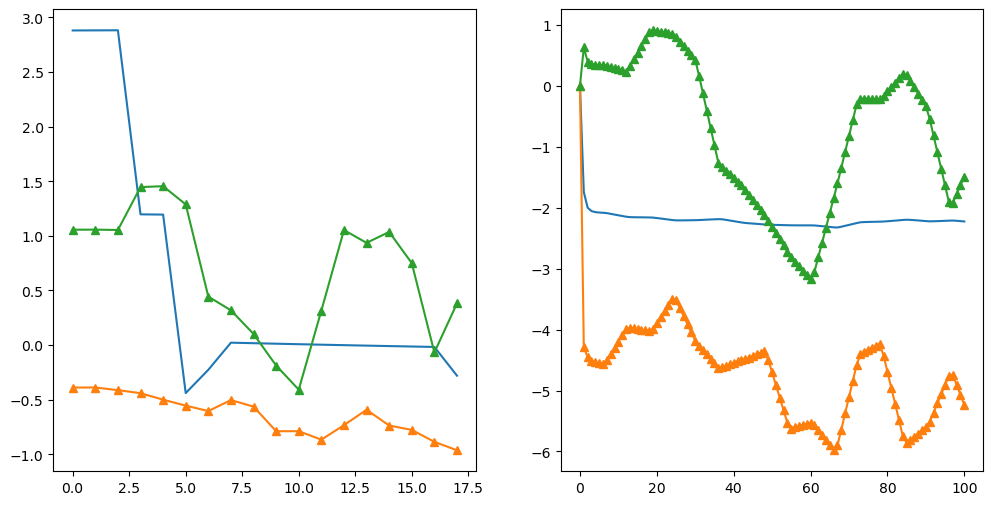

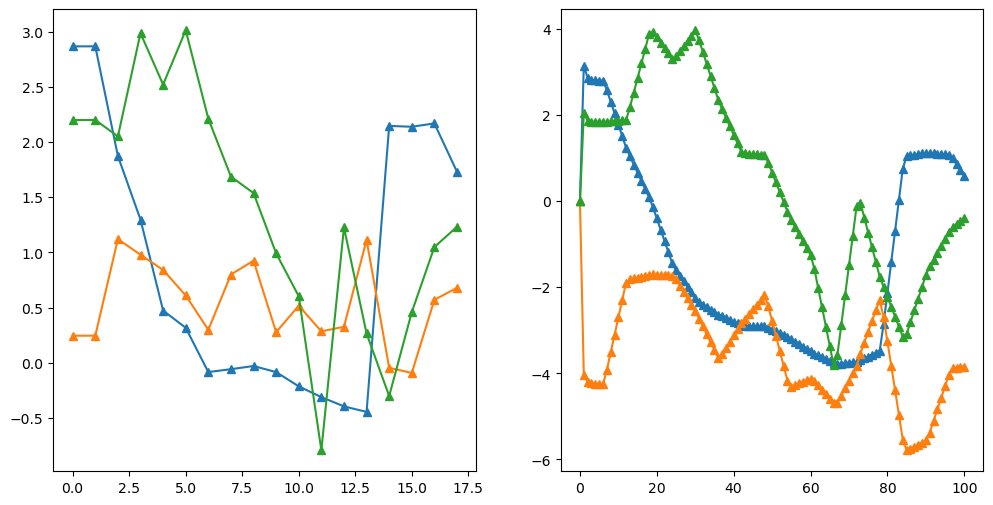

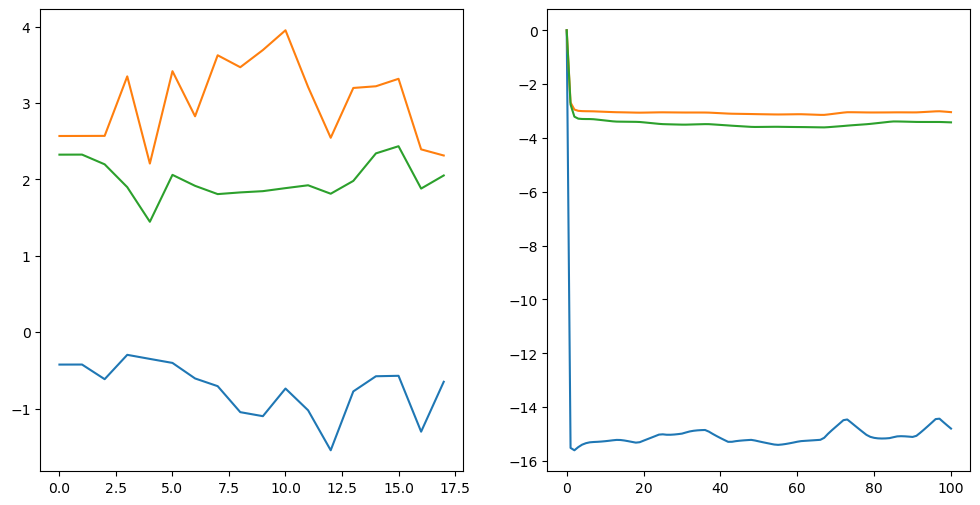

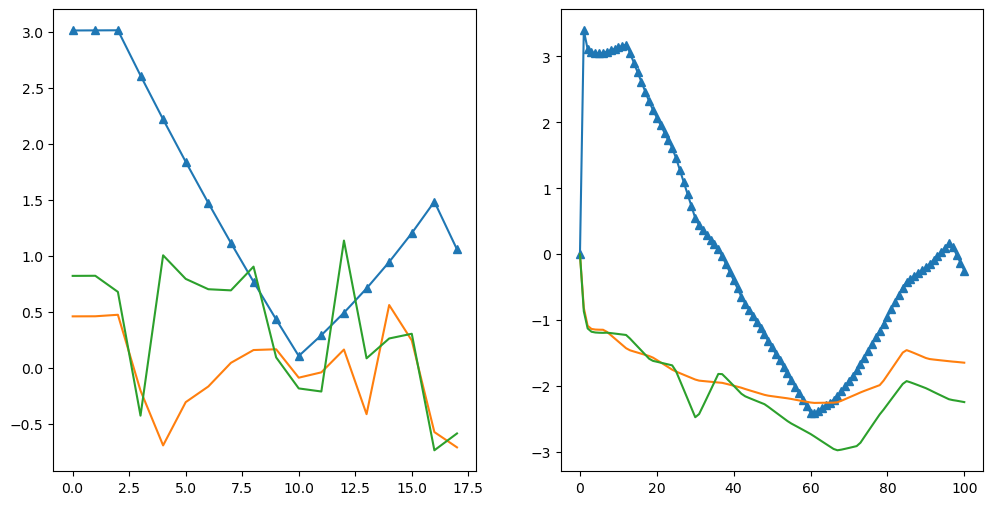

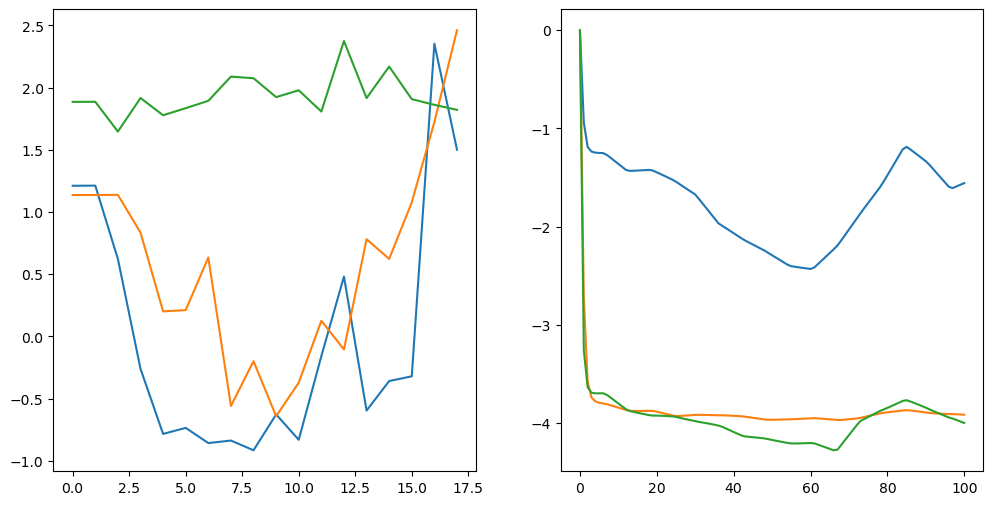

In [32]:
voltage = np.array(model.V_store)


for z in range(5):
    fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(12, 6))
    
    for i in range(3*z, 3*(z+1)):
        if i in sensory_indices:
            axs[0].plot(re_trace[:18, i], marker='^')
        else:
            axs[0].plot(re_trace[:18, i])
    
    for i in range(3*z, 3*(z+1)):
        if i in sensory_indices:
            axs[1].plot(voltage[::10, i], marker='^')
        else:
            axs[1].plot(voltage[::10, i])
    
    plt.show()